In [ ]:

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm



class HopfieldNetwork(object):
    def train_weights(self, train_data):
        print("Start to train weights...")
        num_data =  len(train_data)
        self.num_neuron = train_data[0].shape[0]
        print(f'Number of neuron: {self.num_neuron}')

        # initialize weights
        W = np.zeros((self.num_neuron, self.num_neuron))
        rho = np.sum([np.sum(t) for t in train_data]) / (num_data*self.num_neuron)

        # Hebb rule
        for i in tqdm(range(num_data)):
            t = train_data[i] - rho
            W += np.outer(t, t)

        # Make diagonal element of W into 0
        diagW = np.diag(np.diag(W))
        W = W - diagW
        W /= num_data

        self.W = W

    def predict(self, data, num_iter=20, threshold=0, asyn=False):
        print("Start to predict...")
        self.num_iter = num_iter
        self.threshold = threshold
        self.asyn = asyn

        # Copy to avoid call by reference
        copied_data = np.copy(data)

        # Define predict list
        predicted = []
        all_intermediate_results = []
        energy_over_time_list = []

        for i in tqdm(range(len(data))):
            intermediate_results, final_output, energy_over_time = self._run(copied_data[i])
            predicted.append(final_output)
            all_intermediate_results.append(intermediate_results)
            energy_over_time_list.append(energy_over_time)
              # Visualize energy

        return predicted, all_intermediate_results, energy_over_time_list



    def _run(self, init_s):
        intermediate_results = []  # List to store intermediate results
        energy_over_time = []  # List to store energy values at each iteration

        if self.asyn == False:
            # Synchronous update with intermediate results
            s = init_s
            e = self.energy(s)
            energy_over_time.append(e)

            for i in range(self.num_iter):
                s = np.sign(self.W @ s - self.threshold)
                e_new = self.energy(s)

                # Store intermediate state and energy
                intermediate_results.append(np.copy(s))
                energy_over_time.append(e_new)

                if e == e_new:
                    break
                e = e_new

        else:
            # Asynchronous update with intermediate results
            s = init_s
            e = self.energy(s)
            energy_over_time.append(e)

            for i in range(self.num_iter):
                for j in range(100):
                    idx = np.random.randint(0, self.num_neuron)
                    s[idx] = np.sign(self.W[idx].T @ s - self.threshold)

                # Store intermediate state and energy
                intermediate_results.append(np.copy(s))
                e_new = self.energy(s)
                energy_over_time.append(e_new)

                if e == e_new:
                    break
                e = e_new

        return intermediate_results, s, energy_over_time




    def energy(self, s):
        return -0.5 * s @ self.W @ s + np.sum(s * self.threshold)


    def plot_weights(self):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.W, cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        plt.tight_layout()
        plt.savefig("weights.png")
        plt.show()

Start to data preprocessing...
Start to train weights...
Number of neuron: 16384


100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


Start to predict...


100%|██████████| 4/4 [04:15<00:00, 63.82s/it]


Show prediction results with intermediate steps...


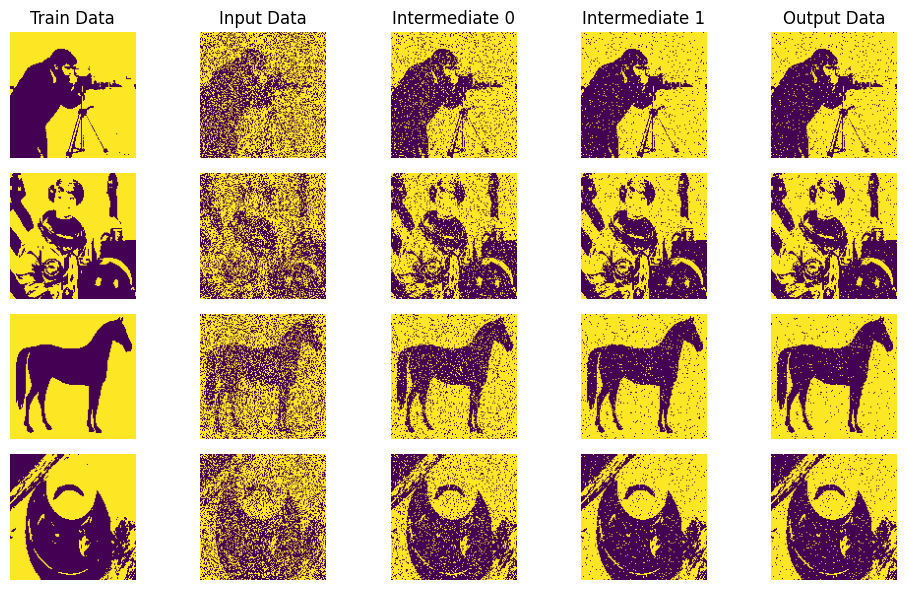

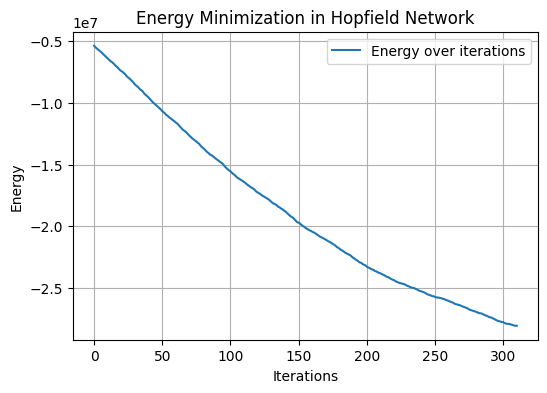

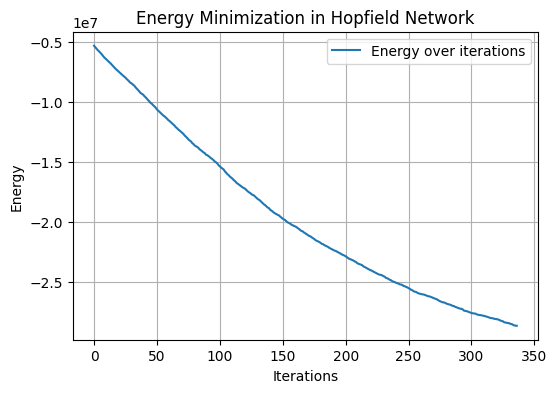

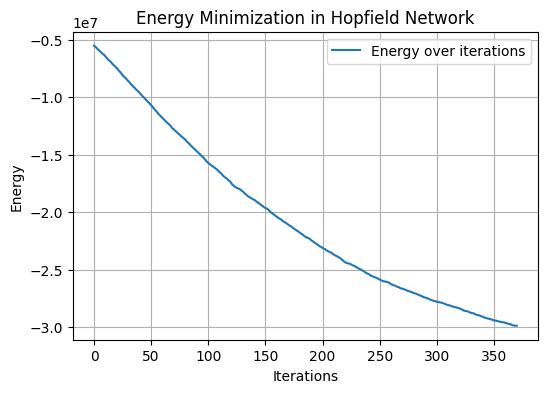

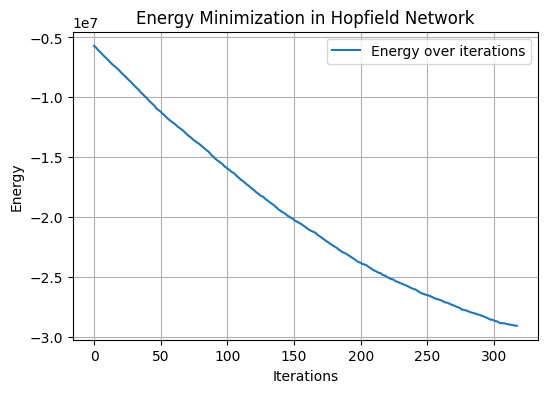

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jul 29 08:40:49 2018

@author: user
"""

import numpy as np
np.random.seed(1)
from matplotlib import pyplot as plt
import skimage.data
from skimage.color import rgb2gray
from skimage.filters import threshold_mean
from skimage.transform import resize

def plot_energy(energy_over_time):
        plt.figure(figsize=(6, 4))
        plt.plot(energy_over_time, label="Energy over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Energy")
        plt.title("Energy Minimization in Hopfield Network")
        plt.legend()
        plt.grid(True)
        plt.show()

# Utils
def get_corrupted_input(input, corruption_level):
    corrupted = np.copy(input)
    inv = np.random.binomial(n=1, p=corruption_level, size=len(input))
    for i, v in enumerate(input):
        if inv[i]:
            corrupted[i] = -1 * v
    return corrupted

def reshape(data):
    dim = int(np.sqrt(len(data)))
    data = np.reshape(data, (dim, dim))
    return data

def plot(data, test, predicted, intermediate_results, figsize=(10, 6)):
    data = [reshape(d) for d in data]
    test = [reshape(d) for d in test]
    predicted = [reshape(d) for d in predicted]

    # Plotting configuration
    fig, axarr = plt.subplots(len(data), 5, figsize=figsize)  # 5 columns for input, test, 3 intermediate, output

    for i in range(len(data)):
        if i == 0:
            axarr[i, 0].set_title('Train Data')
            axarr[i, 1].set_title("Input Data")
            axarr[i, 2].set_title('Intermediate 0')
            axarr[i, 3].set_title('Intermediate 1')
            axarr[i, 4].set_title('Output Data')

        axarr[i, 0].imshow(data[i])
        axarr[i, 0].axis('off')
        axarr[i, 1].imshow(test[i])
        axarr[i, 1].axis('off')

        # Display the first intermediate result if available
        if len(intermediate_results[i]) > 150:
            axarr[i, 2].imshow(reshape(intermediate_results[i][150]))
            axarr[i, 2].axis('off')

        # Display the second intermediate result if available
        if len(intermediate_results[i]) > 300:
            axarr[i, 3].imshow(reshape(intermediate_results[i][300]))
            axarr[i, 3].axis('off')

        axarr[i, 4].imshow(predicted[i])
        axarr[i, 4].axis('off')

    plt.tight_layout()
    plt.savefig("result_with_intermediate.png")
    plt.show()



def preprocessing(img, w=128, h=128):
    # Resize image
    img = resize(img, (w,h), mode='reflect')

    # Thresholding
    thresh = threshold_mean(img)
    binary = img > thresh
    shift = 2*(binary*1)-1 # Boolian to int

    # Reshape
    flatten = np.reshape(shift, (w*h))
    return flatten

def main():
    # Load data
    camera = skimage.data.camera()
    astronaut = rgb2gray(skimage.data.astronaut())
    horse = skimage.data.horse()
    coffee = rgb2gray(skimage.data.coffee())

    # Marge data
    data = [camera, astronaut, horse, coffee]

    # Preprocessing
    print("Start to data preprocessing...")
    data = [preprocessing(d) for d in data]

    # Create Hopfield Network Model
    model = HopfieldNetwork()
    model.train_weights(data)

    # Generate testset
    test = [get_corrupted_input(d, 0.3) for d in data]

    predicted, intermediate_results, energy_over_time_list = model.predict(test,num_iter = 500, threshold=0, asyn=True)

    print("Show prediction results with intermediate steps...")
    plot(data, test, predicted, intermediate_results)
    for energy_over_time in energy_over_time_list:
        plot_energy(energy_over_time)
    # print("Show network weights matrix...")
    # model.plot_weights()

if __name__ == '__main__':
    main()